# 0. Environment settings

In [1]:
# Import libraries
from octis.models.CTM import CTM
from octis.models.ETM import ETM
from octis.models.HDP import HDP
from octis.models.LDA import LDA
from octis.models.LSI import LSI
from octis.models.NMF import NMF
from octis.models.ProdLDA import ProdLDA
from octis.dataset.dataset import Dataset
from octis.models.NeuralLDA import NeuralLDA
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Categorical, Integer
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
sns.set_context("paper")
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "SF Pro Display"

In [2]:
def symmetrize_y_axis(axes, y_min, y_max):
    # y_max = np.abs(axes.get_ylim()).max()
    axes.set_ylim(ymin=y_min, ymax=y_max)

In [3]:
# Define globally
# n_topics = 10
model_runs = 1
optimization_runs = 1

In [4]:
# Load dataset
dataset = Dataset()
dataset.load_custom_dataset_from_folder("datasets/acordao")

/home/matheus/anaconda3/lib/python3.9/site-packages/octis/dataset/dataset.py:330: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = df[df[1] == 'train'].append(df[df[1] == 'val'])
/home/matheus/anaconda3/lib/python3.9/site-packages/octis/dataset/dataset.py:331: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(df[df[1] == 'test'])


In [5]:
# Define metric for tunning
topic_coherence = Coherence(texts=dataset.get_corpus())

# Define other metrics
topic_diversity = TopicDiversity(topk=10)

# 1. Hyperparameters tunning

In [6]:
def optimize(model: any, search_space: dict, save_path: str, csv_path: str):
    """
    Optimize a given model in a search space.

    """
    
    # Create optimizer
    optimizer = Optimizer()

    # Optimize
    ctm_optimization_result = optimizer.optimize(
        model,
        dataset,
        topic_diversity,
        search_space,
        random_state=42,
        model_runs=model_runs, 
        save_models=True, 
        extra_metrics=[topic_coherence], # to keep track of other metrics
        number_of_call=optimization_runs,
        save_path=save_path)

    # Export csv
    ctm_optimization_result.save_to_csv(csv_path)

## 1.1 CTM

In [7]:
# Define search space
ctm_search_space = {
    "n_topics": list(range(10, 41, 10)),
    "num_layers": Categorical({1, 2, 3, 4}), 
    "num_neurons": Categorical({10, 30, 50, 100, 200, 300}),
    "activation": Categorical({'softplus', 'relu', 'sigmoid', 'swish', 'tanh', 'leakyrelu', 'rrelu', 'elu', 'selu'}),
    "solver": Categorical({"adam", "sgd"}),
    "dropout": Real(0.0, 0.95)
}

In [8]:
# %%capture

# Define model and optimize
model_ctm = CTM()
optimize(model_ctm, 
         ctm_search_space, 
         "tunning/test_ctm//", 
         "tunning_results/results_ctm.csv"
         )

Current call:  0


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 1.2 ETM

In [30]:
# Define search space
etm_search_space = {
    "n_topics": list(range(10, 41, 10)),
    "optimizer": Categorical({"adam", "adagrad", "adadelta", "rmsprop", "asgd", "sgd"}),
    "t_hidden_size": Integer(400, 1000),
    "rho": Integer(200, 600),
    "num_neurons": Categorical({100, 200, 300}),
    "activation": Categorical({'sigmoid', 'relu', 'softplus'}), 
    "dropout": Real(0.0, 0.95)
}

In [31]:
%%capture

model_etm = ETM(device="gpu")
optimize(model_etm, 
         etm_search_space, 
         "tunning/test_etm//", 
         "tunning_results/results_etm.csv"
         )

## 1.3 HDP

In [ ]:
# Define search space
hdp_search_space = {
    "optimizer": Categorical({"adam", "adagrad", "adadelta", "rmsprop", "asgd", "sgd"}),
    "t_hidden_size": Integer(400, 1000),
    "rho": Integer(200, 600),
    "num_neurons": Categorical({100, 200, 300}),
    "activation": Categorical({'sigmoid', 'relu', 'softplus'}), 
    "dropout": Real(0.0, 0.95)
}

In [ ]:
model_hdp = HDP()
optimize(model_hdp, 
         hdp_search_space, 
         "tunning/test_hdp//", 
         "tunning_results/results_hdp.csv"
         )

## 1.4 LDA

In [7]:
# Define search space
lda_search_space = {
    "num_topics": list(range(10, 41, 10)),
    "passes": list(range(10, 101, 10)),
    "iterations": list(range(10, 1001, 10)),
}

In [8]:
model_lda = LDA()
optimize(model_lda, 
         lda_search_space, 
         "tunning/test_lda//", 
         "tunning_results/results_lda.csv"
         )

Current call:  0


KeyboardInterrupt: 

## 1.5 LSI

## 1.6 NMF

## 1.7 NeuralLDA

## 1.8 ProdLDA

# 2. Visualization

In [148]:
def visualize_model_along_exec(path: str, alg_name: str):
    
    # Read dataset
    df = pd.read_csv(path)

    # Get model_runs
    model_runs = df["Mean(model_runs)"]
    topic_div = df["Coherence(not optimized)"]

    # Define executions
    execs = list(range(len(model_runs)))

    fig, ax = plt.subplots()
    # fig = plt.figure()
    
    # Define axis and title
    plt.xlabel("Execução")
    plt.title("Desempenho ao longo do espaço de busca - " + alg_name)

    # Define topic coherence plot
    ax1 = sns.lineplot(x=execs, y=model_runs, color=sns.color_palette("tab10")[0], label="TC mean")
    ax1.set_ylabel("Topic Coherence")
    symmetrize_y_axis(ax1, -0.6, 0.9)
    ax1.get_legend().remove()

    # Define topic diversity plot
    plt.xlabel("Execution")
    plt.title("Performance along search space - " + alg_name)
    ax2 = ax1.twinx()
    ax2 = sns.lineplot(x=execs, y=topic_div, color=sns.color_palette("tab10")[1], label="TD mean")
    ax2.grid(False)
    ax2.set_ylabel("Topic Diversity")
    symmetrize_y_axis(ax2, 0.2, 1.0)
    ax2.get_legend().remove()

    # Legend
    fig.legend(loc="upper right", bbox_to_anchor=(0.95,0.2), bbox_transform=ax.transAxes)

    # Export
    plt.savefig("plots/" + alg_name + ".svg", format='svg', dpi=300)

    # Show
    plt.show()

    # Get best
    best_conf = df.sort_values(by="Mean(model_runs)", ascending=False).head(1).to_numpy()

    # Print params
    print("Best params")
    for i in list(range(len(df.columns))):
        print(df.columns[i] + " = " + str(best_conf[0][i])) 

## 2.1 CTM

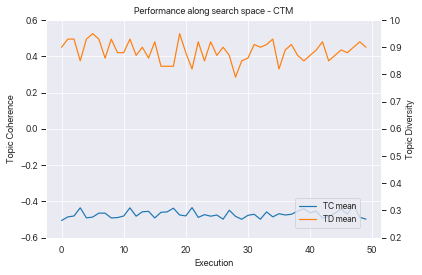

Best params
dataset = dataset_name
surrogate model = RF
acquisition function = LCB
num_iteration = 47
time = 8.919326305389404
Median(model_runs) = -0.4086645485583583
Mean(model_runs) = -0.419123180876938
Standard_Deviation(model_runs) = 0.0346942220025829
activation = softplus
dropout = 0.9013103034463096
n_topics = 40
num_layers = 1
num_neurons = 50
Topic diversity(not optimized) = 0.9


In [126]:
visualize_model_along_exec("tunning_results/results_ctm.csv", "CTM")

## 2.2 ETM

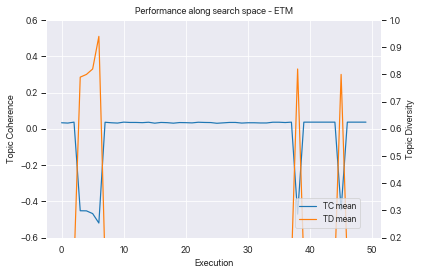

Best params
dataset = dataset_name
surrogate model = RF
acquisition function = LCB
num_iteration = 49
time = 7.224845886230469
Median(model_runs) = 0.0366367759205533
Mean(model_runs) = 0.0366367759205533
Standard_Deviation(model_runs) = 0.0
activation = relu
dropout = 0.4467841703814587
n_topics = 30
num_neurons = 100
optimizer = adagrad
rho = 228
t_hidden_size = 429
Topic diversity(not optimized) = 0.1


In [127]:
visualize_model_along_exec("tunning_results/results_etm.csv", "ETM")

## 2.3 HDP

## 2.4 LDA

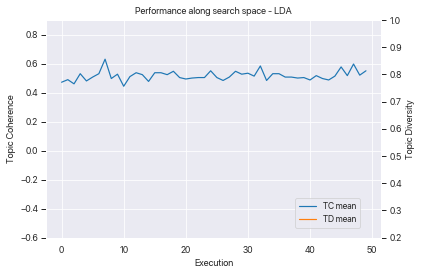

Best params
dataset = dataset_name
surrogate model = RF
acquisition function = LCB
num_iteration = 7
time = 23.665756940841675
Median(model_runs) = 0.64
Mean(model_runs) = 0.63
Standard_Deviation(model_runs) = 0.0294392028877595
iterations = 10
num_topics = 10
passes = 80
Coherence(not optimized) = -0.1173136667019642


In [149]:
visualize_model_along_exec("tunning_results/results_lda.csv", "LDA")